# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
image_dir = Path('/kaggle/input/upscaled-dataset-balanced')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(10)

Filepath                  Label
0  /kaggle/input/upscaled-dataset-balanced/Upscal...          mild_upscaled
1  /kaggle/input/upscaled-dataset-balanced/Upscal...         no_dr_upscaled
2  /kaggle/input/upscaled-dataset-balanced/Upscal...  upscaled_poliferative
3  /kaggle/input/upscaled-dataset-balanced/Upscal...      moderate_upscaled
4  /kaggle/input/upscaled-dataset-balanced/Upscal...          mild_upscaled
5  /kaggle/input/upscaled-dataset-balanced/Upscal...        severe_upscaled
6  /kaggle/input/upscaled-dataset-balanced/Upscal...      moderate_upscaled
7  /kaggle/input/upscaled-dataset-balanced/Upscal...      moderate_upscaled
8  /kaggle/input/upscaled-dataset-balanced/Upscal...      moderate_upscaled
9  /kaggle/input/upscaled-dataset-balanced/Upscal...  upscaled_poliferative

## Visualization

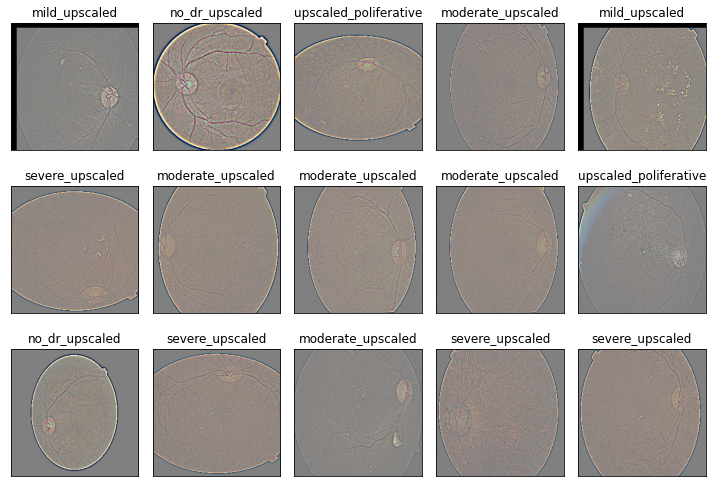

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

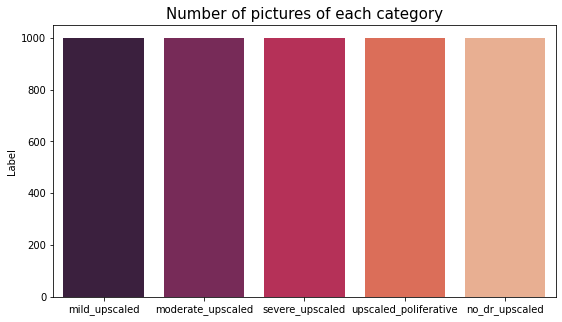

In [5]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# 2. Load the Images with a generator<a class="anchor" id="2"></a>

In [6]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [7]:
import tensorflow as tf

def balanced_weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Apply class weights
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        unweighted_losses = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
        weighted_losses = unweighted_losses * weights
        return tf.reduce_mean(weighted_losses)
    return loss

def get_model(model):
    # Load the pretrained model
    kwargs = {'input_shape': (224, 224, 3),
              'include_top': False,
              'weights': 'imagenet',
              'pooling': 'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Define class weights (You need to calculate or set these weights based on your dataset)
    class_weights = [1.0, 1.0, 1.0, 1.0, 1.0]  # Example weights, adjust according to your dataset

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Example usage:
# model = get_model(tf.keras.applications.MobileNetV2)


In [8]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [9]:
# Dictionary with the models
models = {
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    
    
    
    
    
   
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 4046 validated image filenames belonging to 5 classes.
Found 449 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


127/127 [==============================] - 639s 5s/step - loss: 1.1599 - accuracy: 0.5131 - val_loss: 0.7524 - val_accuracy: 0.6993
DenseNet201          trained in 639.13 sec
127/127 [==============================] - 398s 3s/step - loss: 1.4107 - accuracy: 0.3594 - val_loss: 1.1986 - val_accuracy: 0.4699
ResNet50             trained in 398.69 sec
127/127 [==============================] - 1406s 11s/step - loss: 1.4156 - accuracy: 0.3775 - val_loss: 1.1179 - val_accuracy: 0.4967
VGG19                trained in 1406.07 sec


In [10]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  train_accuracy  val_accuracy  Training time (sec)
0  DenseNet201          0.5976        0.6993               639.13
1        VGG19          0.4498        0.4967              1406.07
2     ResNet50          0.4016        0.4699               398.69

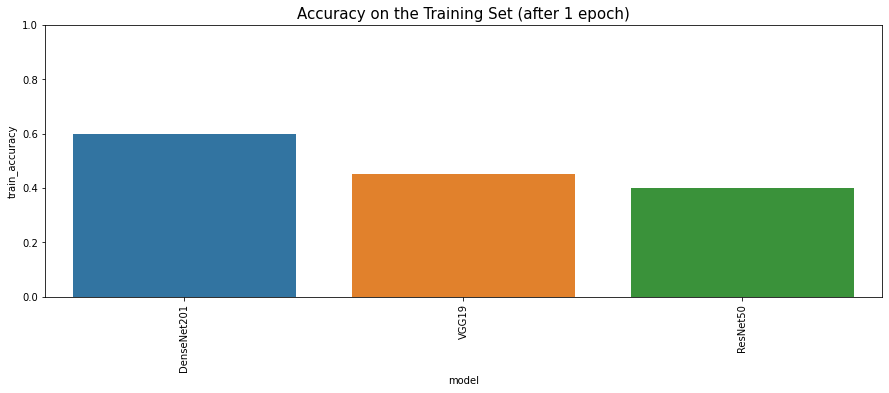

In [11]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

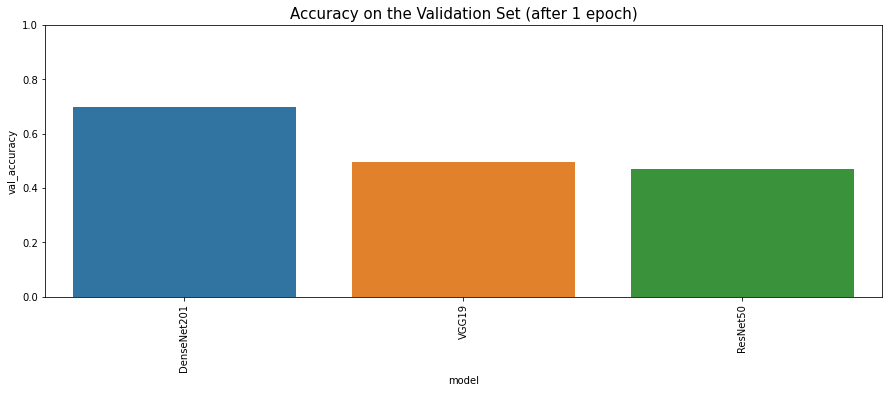

In [12]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the Validation Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

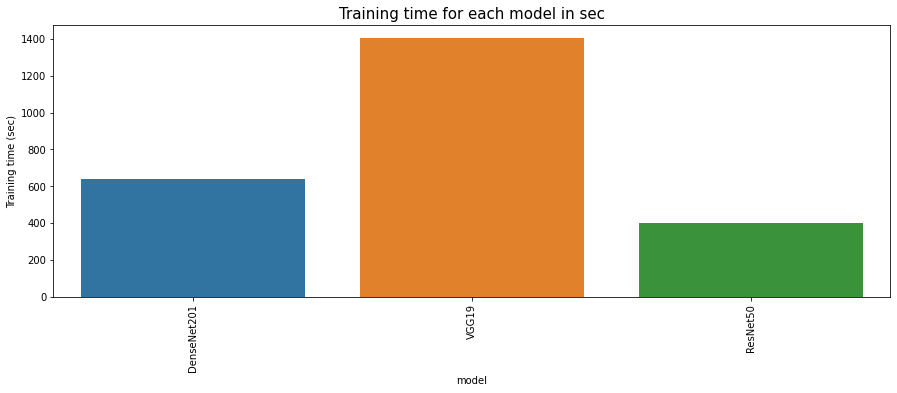

In [13]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 3. DENSENET201<a class="anchor" id="4"></a>

In [19]:
# Load the pretained model
pretrained_model = tf.keras.applications.DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


pretrained_model.trainable = False

In [20]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
127/127 [==============================] - 611s 5s/step - loss: 1.1375 - accuracy: 0.5168 - val_loss: 0.8764 - val_accuracy: 0.6392
Epoch 2/10
127/127 [==============================] - 592s 5s/step - loss: 0.6907 - accuracy: 0.7145 - val_loss: 0.7282 - val_accuracy: 0.7149
Epoch 3/10
127/127 [==============================] - 593s 5s/step - loss: 0.5691 - accuracy: 0.7687 - val_loss: 0.5504 - val_accuracy: 0.7661
Epoch 4/10
127/127 [==============================] - 606s 5s/step - loss: 0.5291 - accuracy: 0.7781 - val_loss: 0.6808 - val_accuracy: 0.7238
Epoch 5/10
127/127 [==============================] - 604s 5s/step - loss: 0.4891 - accuracy: 0.8043 - val_loss: 0.5201 - val_accuracy: 0.7728
Epoch 6/10
127/127 [==============================] - 586s 5s/step - loss: 0.4220 - accuracy: 0.8207 - val_loss: 0.4880 - val_accuracy: 0.7840
Epoch 7/10
127/127 [==============================] - 589s 5s/step - loss: 0.3818 - accuracy: 0.8500 - val_loss: 0.5167 - val_accuracy: 0.7639

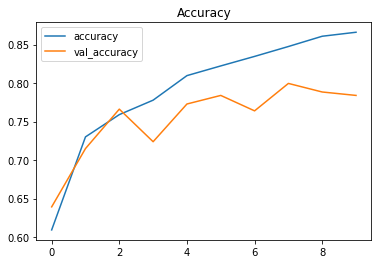

In [21]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

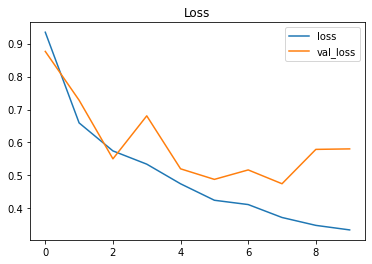

In [22]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# Visualize the result<a class="anchor" id="5"></a>

In [23]:
results = model.evaluate(test_images, verbose=0)

In [24]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.44134

## Accuracy on the test set: 81.20%

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['no_dr_upscaled', 'mild_upscaled', 'upscaled_poliferative', 'no_dr_upscaled', 'upscaled_poliferative']


In [26]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                       precision    recall  f1-score   support

        mild_upscaled       0.73      0.74      0.73        95
    moderate_upscaled       0.96      0.87      0.91       108
       no_dr_upscaled       0.95      0.99      0.97       106
      severe_upscaled       0.76      0.74      0.75        95
upscaled_poliferative       0.64      0.70      0.67        96

             accuracy                           0.81       500
            macro avg       0.81      0.81      0.81       500
         weighted avg       0.82      0.81      0.81       500



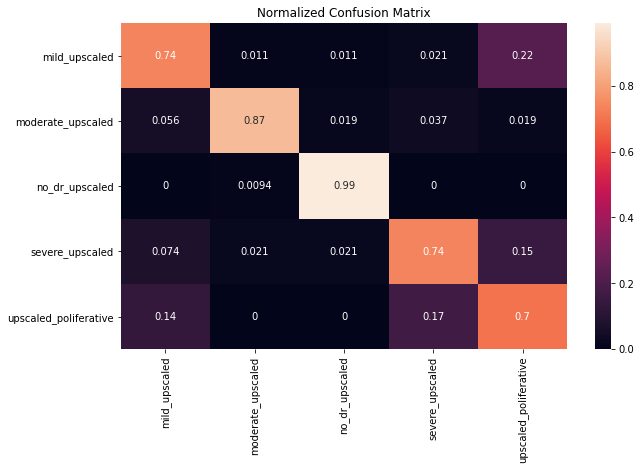

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

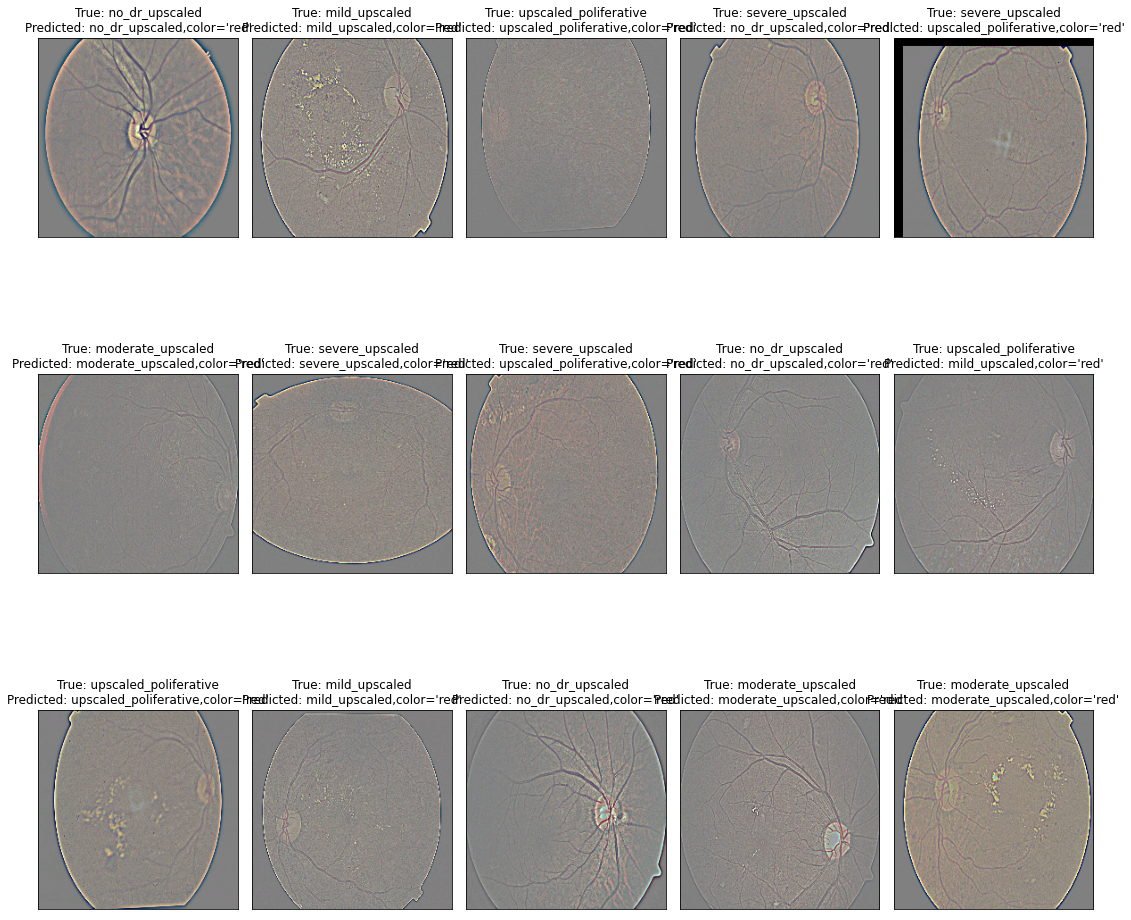

In [28]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]},color='red'")
plt.tight_layout()
plt.show()

# 4. RESNET 50<a class="anchor" id="6"></a>

In [29]:
# Load the pretained model
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


pretrained_model.trainable = False

In [30]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
127/127 [==============================] - 409s 3s/step - loss: 1.4467 - accuracy: 0.3403 - val_loss: 1.2127 - val_accuracy: 0.5122
Epoch 2/10
127/127 [==============================] - 411s 3s/step - loss: 1.2272 - accuracy: 0.4705 - val_loss: 1.1008 - val_accuracy: 0.5323
Epoch 3/10
127/127 [==============================] - 402s 3s/step - loss: 1.1198 - accuracy: 0.5219 - val_loss: 1.0098 - val_accuracy: 0.5635
Epoch 4/10
127/127 [==============================] - 403s 3s/step - loss: 1.0174 - accuracy: 0.5626 - val_loss: 1.0115 - val_accuracy: 0.5546
Epoch 5/10
127/127 [==============================] - 413s 3s/step - loss: 0.9367 - accuracy: 0.6045 - val_loss: 1.3857 - val_accuracy: 0.4566


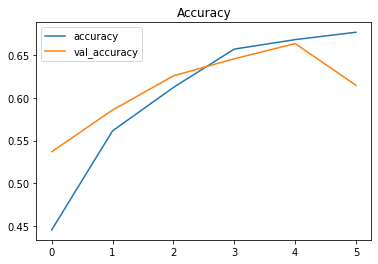

In [48]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

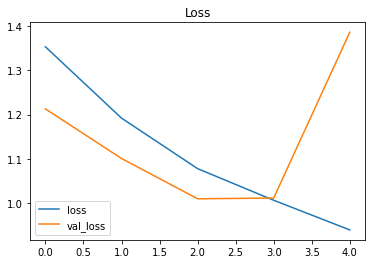

In [31]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [32]:
results = model.evaluate(test_images, verbose=0)

In [33]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 1.02780

## Accuracy on the test set: 56.40%

In [34]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['no_dr_upscaled', 'severe_upscaled', 'severe_upscaled', 'moderate_upscaled', 'upscaled_poliferative']


In [35]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                       precision    recall  f1-score   support

        mild_upscaled       0.53      0.33      0.41        95
    moderate_upscaled       0.87      0.63      0.73       108
       no_dr_upscaled       0.78      0.89      0.83       106
      severe_upscaled       0.34      0.67      0.45        95
upscaled_poliferative       0.46      0.26      0.33        96

             accuracy                           0.56       500
            macro avg       0.60      0.56      0.55       500
         weighted avg       0.61      0.56      0.56       500



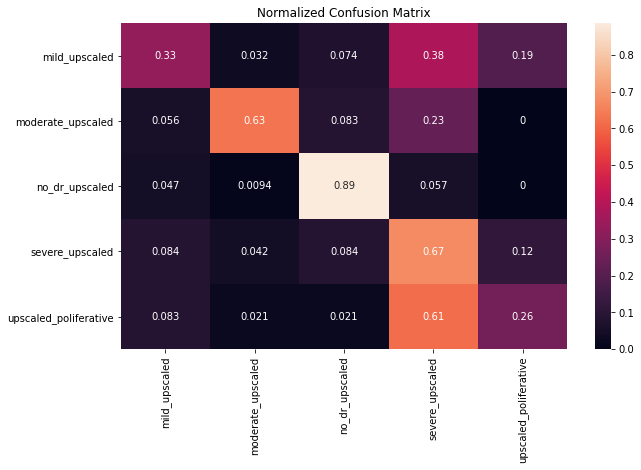

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

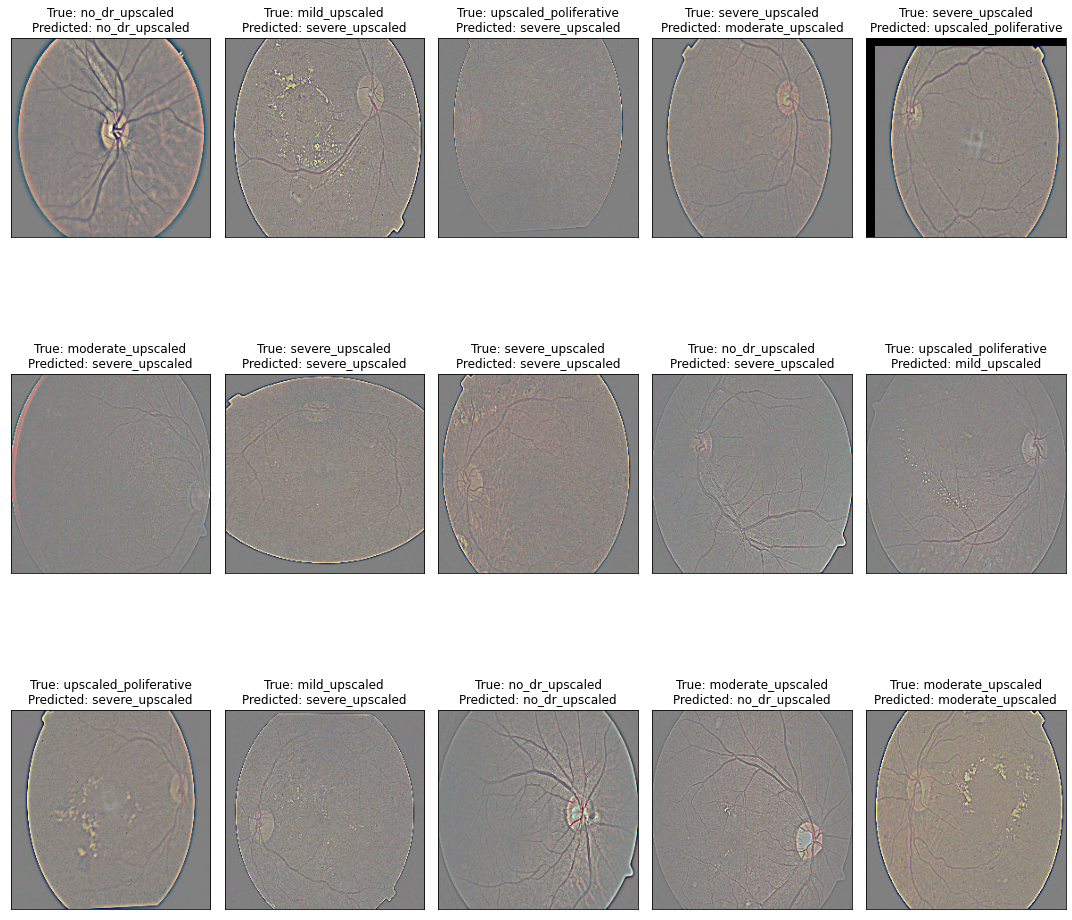

In [37]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 5. VGG19<a class="anchor" id="7"></a>

In [38]:
# Load the pretained model
pretrained_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)


pretrained_model.trainable = False

In [39]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
127/127 [==============================] - 1416s 11s/step - loss: 1.4244 - accuracy: 0.3707 - val_loss: 1.1103 - val_accuracy: 0.5367
Epoch 2/10
127/127 [==============================] - 1416s 11s/step - loss: 1.0849 - accuracy: 0.5382 - val_loss: 0.9677 - val_accuracy: 0.5857
Epoch 3/10
127/127 [==============================] - 1413s 11s/step - loss: 0.9497 - accuracy: 0.6043 - val_loss: 0.8793 - val_accuracy: 0.6258
Epoch 4/10
127/127 [==============================] - 1408s 11s/step - loss: 0.8531 - accuracy: 0.6409 - val_loss: 0.8289 - val_accuracy: 0.6459
Epoch 5/10
127/127 [==============================] - 1410s 11s/step - loss: 0.7723 - accuracy: 0.6747 - val_loss: 0.8391 - val_accuracy: 0.6637
Epoch 6/10
127/127 [==============================] - 1408s 11s/step - loss: 0.7605 - accuracy: 0.6705 - val_loss: 0.9041 - val_accuracy: 0.6147


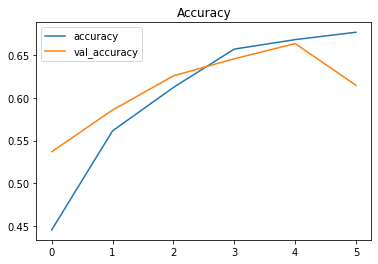

In [40]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [41]:
results = model.evaluate(test_images, verbose=0)

In [42]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.81358

## Accuracy on the test set: 65.00%

In [43]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['no_dr_upscaled', 'mild_upscaled', 'moderate_upscaled', 'moderate_upscaled', 'severe_upscaled']


In [44]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                       precision    recall  f1-score   support

        mild_upscaled       0.59      0.51      0.54        95
    moderate_upscaled       0.70      0.81      0.76       108
       no_dr_upscaled       0.85      0.97      0.91       106
      severe_upscaled       0.58      0.43      0.49        95
upscaled_poliferative       0.45      0.47      0.46        96

             accuracy                           0.65       500
            macro avg       0.63      0.64      0.63       500
         weighted avg       0.64      0.65      0.64       500



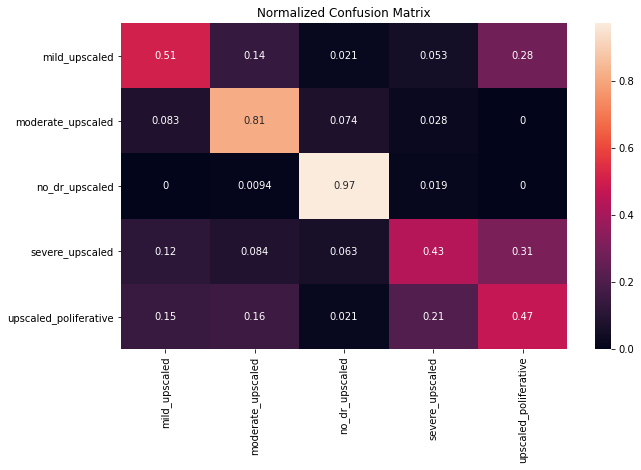

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

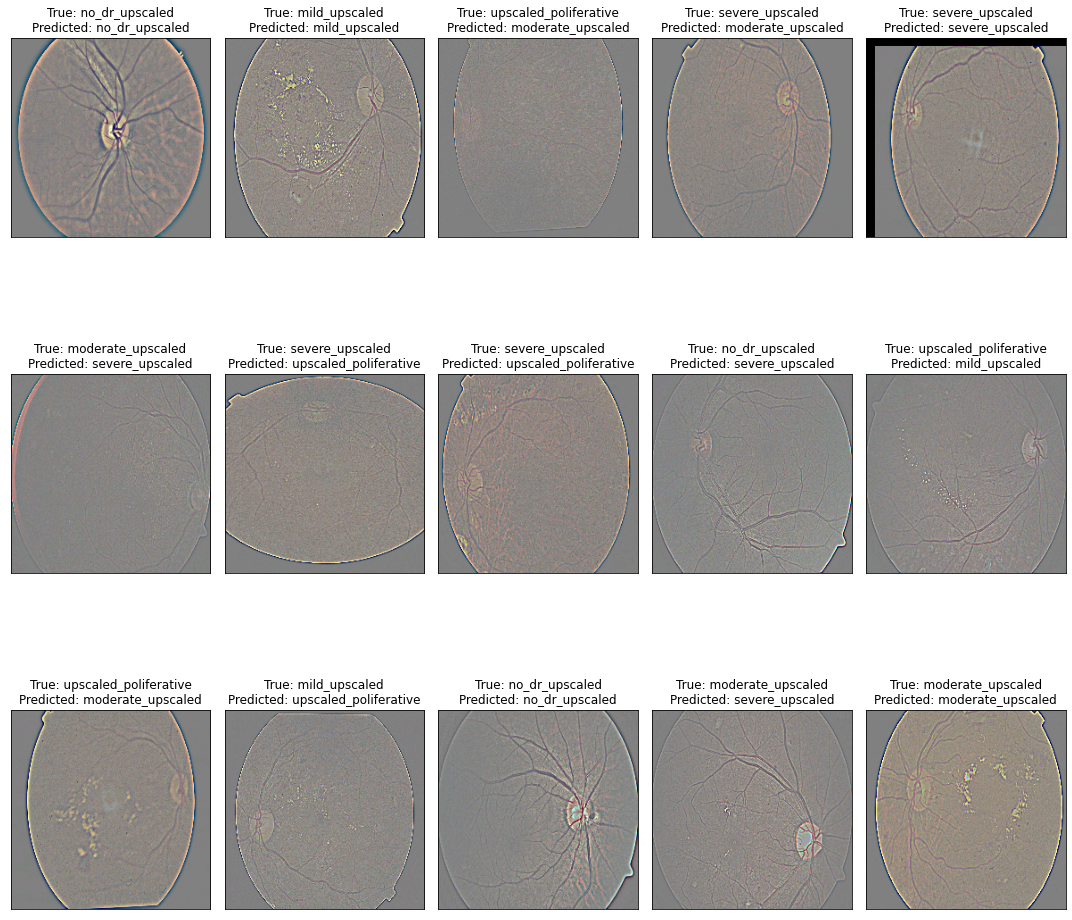

In [46]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [47]:
results = model.evaluate(test_images, verbose=0)
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.81358

## Accuracy on the test set: 65.00%

# 6. MOBILENET V2<a class="anchor" id="8"></a>

# 7. NASNet Mobile<a class="anchor" id="9"></a>

# 8. XCEPTION<a class="anchor" id="10"></a>

# 9. Efficient Net B7<a class="anchor" id="10"></a>